In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

file_path = "./sampled_data.csv"

# 1. 데이터 로드
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

In [39]:
# 2. 시간 데이터 처리
def process_time_data(df):
    # event_time을 datetime 형식으로 변환
    df['event_time'] = pd.to_datetime(df['event_time'])
    
    # epc_code별로 시간 차이 계산
    df['time_diff'] = df.groupby('epc_code')['event_time'].diff().dt.total_seconds().fillna(0)
    
    # 시간의 순환적 특성 인코딩
    df['hour'] = df['event_time'].dt.hour
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    return df

In [40]:
# 3. Label Encoding
def encode_categorical_data(df):
    # Label Encoding for hub_type and event_type
    le_hub = LabelEncoder()
    le_event = LabelEncoder()
    df['hub_type_encoded'] = le_hub.fit_transform(df['hub_type'])
    df['event_type_encoded'] = le_event.fit_transform(df['event_type'])
    return df

In [41]:
# 4. 시계열 데이터 구성
def create_sequences(df, seq_length):
    sequences = []
    for _, group in df.groupby('epc_code'):
        group_data = group[['time_diff', 'hub_type_encoded', 'event_type_encoded']].values
        for i in range(len(group_data) - seq_length + 1):
            sequences.append(group_data[i:i + seq_length])
    return np.array(sequences)


In [42]:
# 5. 데이터 정규화
def normalize_data(sequences):
    scaler = MinMaxScaler()
    for feature_idx in range(sequences.shape[2]):
        sequences[:, :, feature_idx] = scaler.fit_transform(sequences[:, :, feature_idx])
    return sequences

In [43]:
# 6. 데이터 분할
def split_data(sequences, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    X_train, X_temp = train_test_split(sequences, test_size=val_ratio + test_ratio, random_state=42)
    X_val, X_test = train_test_split(X_temp, test_size=test_ratio / (val_ratio + test_ratio), random_state=42)
    return X_train, X_val, X_test

In [44]:
# 7. Autoencoder 모델 생성
def build_autoencoder(seq_length, feature_dim):
    input_seq = layers.Input(shape=(seq_length, feature_dim))
    x = layers.LSTM(64, activation='relu', return_sequences=True)(input_seq)
    x = layers.LSTM(32, activation='relu', return_sequences=False)(x)
    latent = layers.Dense(16, activation='relu')(x)
    x = layers.RepeatVector(seq_length)(latent)
    x = layers.LSTM(32, activation='relu', return_sequences=True)(x)
    x = layers.LSTM(64, activation='relu', return_sequences=True)(x)
    output_seq = layers.TimeDistributed(layers.Dense(feature_dim))(x)
    autoencoder = models.Model(input_seq, output_seq)
    return autoencoder

In [45]:
# 8. 재구성 결과 시각화
def visualize_reconstruction(X_test, reconstructed, n_samples=5):
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 10))
    for i in range(n_samples):
        axes[i, 0].plot(X_test[i].flatten(), label="Original", alpha=0.7)
        axes[i, 0].set_title(f"Original Sequence {i+1}")
        axes[i, 0].legend()
        axes[i, 1].plot(reconstructed[i].flatten(), label="Reconstructed", alpha=0.7, linestyle="--")
        axes[i, 1].set_title(f"Reconstructed Sequence {i+1}")
        axes[i, 1].legend()
    plt.tight_layout()
    plt.show()

In [46]:
# 9. 재구성 오류 분포 시각화
def plot_reconstruction_error(X_test, reconstructed):
    errors = np.mean(np.square(X_test - reconstructed), axis=(1, 2))
    plt.figure(figsize=(8, 5))
    plt.hist(errors, bins=50, alpha=0.75, color='blue', label='Reconstruction Error')
    plt.axvline(np.mean(errors) + 2 * np.std(errors), color='red', linestyle='--', label='Threshold (Mean + 2*Std)')
    plt.title("Reconstruction Error Distribution")
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    return errors

In [50]:
# 10. 이상치 탐지 및 시각화
def detect_anomalies(errors, threshold):
    anomalies = errors > threshold
    print(f"Number of anomalies detected: {np.sum(anomalies)}")
    return anomalies

def visualize_anomalies(X_test, reconstructed, anomalies, n_samples=5):
    anomaly_indices = np.where(anomalies)[0]
    
    if len(anomaly_indices) == 0:
        print("No anomalies detected.")
        return
    
    selected_indices = anomaly_indices[:n_samples]
    fig, axes = plt.subplots(len(selected_indices), 2, figsize=(10, 10))
    for i, idx in enumerate(selected_indices):
        axes[i, 0].plot(X_test[idx].flatten(), label="Original", alpha=0.7)
        axes[i, 0].set_title(f"Anomalous Sequence {idx+1}: Original")
        axes[i, 0].legend()
        axes[i, 1].plot(reconstructed[idx].flatten(), label="Reconstructed", alpha=0.7, linestyle="--")
        axes[i, 1].set_title(f"Anomalous Sequence {idx+1}: Reconstructed")
        axes[i, 1].legend()
    plt.tight_layout()
    plt.show()

In [51]:
# 11. 파이프라인 실행
def preprocess_pipeline(file_path, seq_length=10):
    df = load_data(file_path)
    df = process_time_data(df)
    df = encode_categorical_data(df)
    sequences = create_sequences(df, seq_length)
    sequences = normalize_data(sequences)
    X_train, X_val, X_test = split_data(sequences)
    return X_train, X_val, X_test

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - loss: 0.1564 - val_loss: 0.2127
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1509 - val_loss: 0.2024
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1400 - val_loss: 0.1882
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1313 - val_loss: 0.1681
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1181 - val_loss: 0.1388
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0964 - val_loss: 0.0968
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0742 - val_loss: 0.0685
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0703 - val_loss: 0.0692
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0657 - val_loss: 0.0686
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0602 - val_loss: 0.0782
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0627 - val_loss: 0.0792
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0615 - val_loss: 0.0744


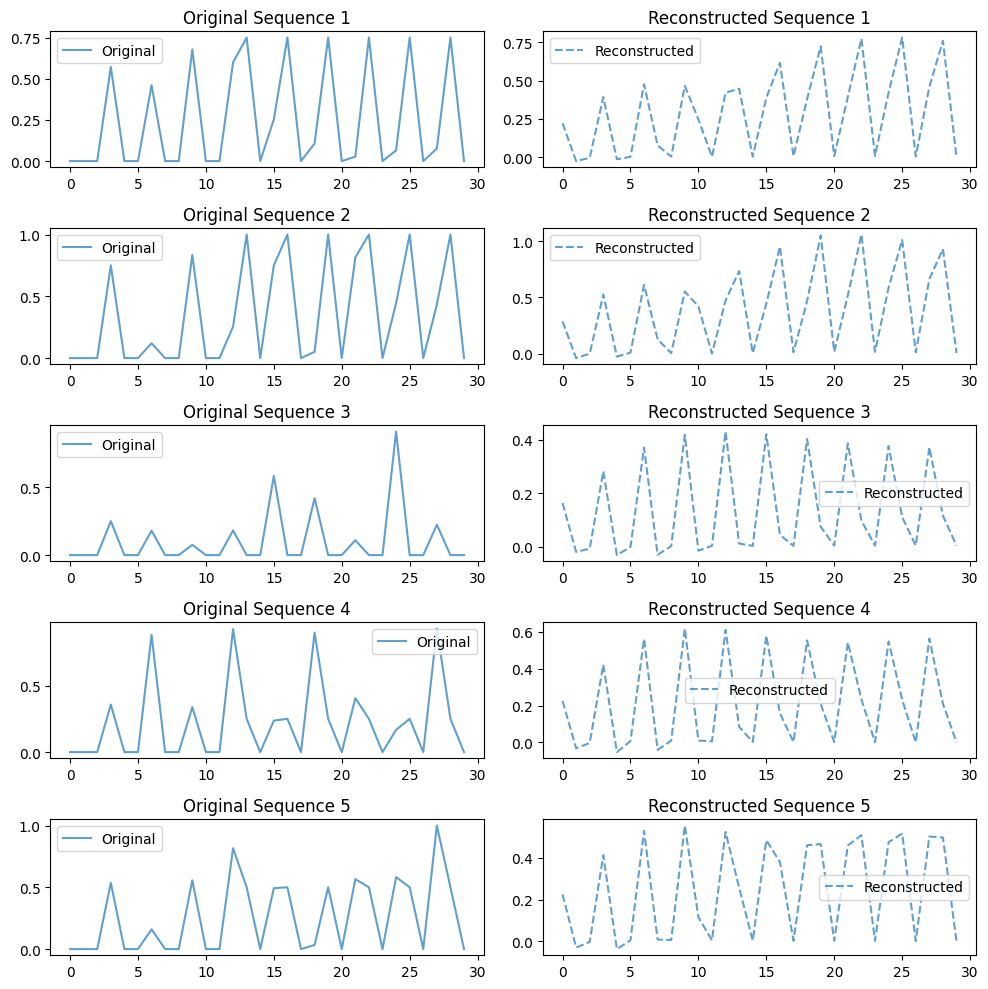

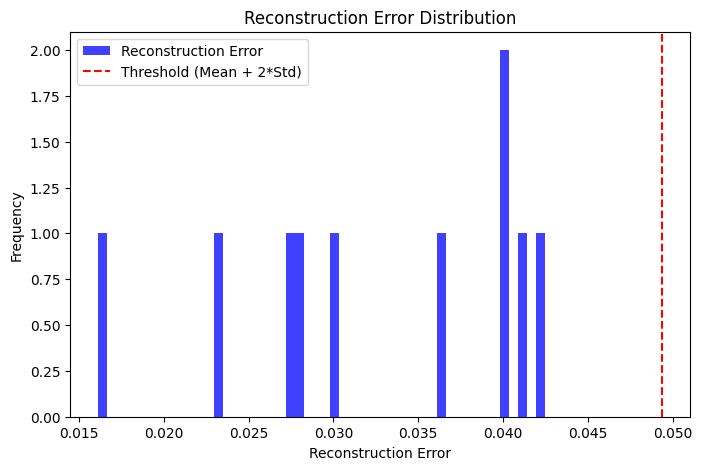

Number of anomalies detected: 0
No anomalies detected.


In [52]:
# 12. 실행
seq_length = 10
X_train, X_val, X_test = preprocess_pipeline(file_path, seq_length)

# Autoencoder 생성 및 학습
feature_dim = X_train.shape[2]
autoencoder = build_autoencoder(seq_length, feature_dim)
autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(X_train, X_train, validation_data=(X_val, X_val), epochs=50, batch_size=32, shuffle=True)

# 테스트 데이터 평가 및 결과 분석
reconstructed = autoencoder.predict(X_test)
visualize_reconstruction(X_test, reconstructed)
reconstruction_errors = plot_reconstruction_error(X_test, reconstructed)

# 이상치 탐지
threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors)
anomalies = detect_anomalies(reconstruction_errors, threshold)
visualize_anomalies(X_test, reconstructed, anomalies)